<a href="https://colab.research.google.com/github/johnoyer/vego_public/blob/main/part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras import layers
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Masking, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

Using the GPU!


In [ ]:
csv_file = '/content/drive/MyDrive/ChicagoFSWildSubset/ChicagoFSWild.csv'
df = pd.read_csv(csv_file)
source_folder = '/content/drive/MyDrive/ChicagoFSWildSubset'
source_folder_2 = '/content/drive/MyDrive/ChicagoFSWildTest'
max_input_length = 0  # Initialize to zero
max_output_length = 0  # Initialize to zero

# Calculate max_input_length and max_output_length
for index, row in tqdm(df.iterrows()):
    folder_path = os.path.join(source_folder, row['filename'])

    # Calculate max_input_length
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
      num_images = len(os.listdir(folder_path))
      if num_images > max_input_length:
          max_input_length = num_images

      # Calculate max_output_length
      label_length = len(row['label_proc'])
      if label_length > max_output_length:
          max_output_length = label_length

print(max_input_length)
print(max_output_length)
X_train = []
y_train = []

from sklearn.preprocessing import LabelEncoder

for index, row in df.iterrows():
    folder_path = os.path.join(source_folder, row['filename'])
    label_sequence = row['label_proc']  # Assuming 'label_sequence' is the column name for the label sequence
    # Example label preprocessing
    # label_encoder = LabelEncoder()
    # label_sequence_encoded = label_encoder.fit_transform(label_sequence)
    # TODO: Add all the neccesary characters from the dataset
    char_to_int = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz &")}  # Mapping from character to integer
    label_sequence_encoded = [char_to_int[char] for char in label_sequence]
    char_to_int['\0'] = 29
    label_sequence_encoded += [char_to_int['\0']] * (max_output_length - len(label_sequence_encoded))
    print(folder_path)
    print(label_sequence)

    image_sequence = []
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
      # print(os.listdir(folder_path))
      for image_file in os.listdir(folder_path):
          image_path = os.path.join(folder_path, image_file)
          image = load_img(image_path, target_size = (96,96))
          image_array = img_to_array(image)  # Convert image to numpy array
          image_sequence.append(image_array)
          # print(image_array.shape)
          # print(len(image_sequence))

      # Pad image to max_input_length
      image_sequence = image_sequence + [np.zeros_like(image_array)] * (max_input_length - len(image_sequence))



      label_sequence_one_hot = to_categorical(label_sequence_encoded, num_classes=30)

      # X_val = []
      # y_val = []

      # if index % 5 == 0:  # split for validation
      #     X_val.append(image_sequence)
      #     y_val.append(label_sequence_one_hot)

      X_train.append(image_sequence)
      y_train.append(label_sequence_one_hot)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# X_val = np.array(X_val)
# y_val = np.array(y_val)



93it [00:00, 727.85it/s]


116
17
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0001
dc
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0002
ed
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0003
aslized
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0004
asl literature
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0005
alized
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0006
asl
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0007
asl
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0008
ed
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0009
asl
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0010
video
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0011
aslized
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0012
aslized
/content/drive/MyDrive/ChicagoFSWildSubset/aslized/elsie_stecker_0013
aslized
/c

In [ ]:
csv_file = '/content/drive/MyDrive/ChicagoFSWildSubset/ChicagoFSWild2.csv'
df = pd.read_csv(csv_file)
# source_folder = '/content/drive/MyDrive/ChicagoFSWildSubset'
# source_folder_2 = '/content/drive/MyDrive/ChicagoFSWildTest'
# max_input_length = 0  # Initialize to zero
# max_output_length = 0  # Initialize to zero

# # Calculate max_input_length and max_output_length
# for index, row in tqdm(df.iterrows()):
#     folder_path = os.path.join(source_folder, row['filename'])

#     # Calculate max_input_length
#     if os.path.exists(folder_path) and os.path.isdir(folder_path):
#       num_images = len(os.listdir(folder_path))
#       if num_images > max_input_length:
#           max_input_length = num_images

#       # Calculate max_output_length
#       label_length = len(row['label_proc'])
#       if label_length > max_output_length:
#           max_output_length = label_length

print(max_input_length)
print(max_output_length)
X_test = []
y_test = []

from sklearn.preprocessing import LabelEncoder

for index, row in df.iterrows():
    folder_path = os.path.join(source_folder_2, row['filename'])
    label_sequence = row['label_proc']  # Assuming 'label_sequence' is the column name for the label sequence
    # Example label preprocessing
    # label_encoder = LabelEncoder()
    # label_sequence_encoded = label_encoder.fit_transform(label_sequence)
    # TODO: Add all the neccesary characters from the dataset
    char_to_int = {char: idx for idx, char in enumerate("abcdefghijklmnopqrstuvwxyz &")}  # Mapping from character to integer
    label_sequence_encoded = [char_to_int[char] for char in label_sequence]
    char_to_int['\0'] = 29
    label_sequence_encoded += [char_to_int['\0']] * (max_output_length - len(label_sequence_encoded))
    print(folder_path)
    print(label_sequence)

    image_sequence = []
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
      # print(os.listdir(folder_path))
      for image_file in os.listdir(folder_path):
          image_path = os.path.join(folder_path, image_file)
          image = load_img(image_path, target_size = (96,96))
          image_array = img_to_array(image)  # Convert image to numpy array
          image_sequence.append(image_array)
          # print(image_array.shape)
          # print(len(image_sequence))

      # Pad image to max_input_length
      image_sequence = image_sequence + [np.zeros_like(image_array)] * (max_input_length - len(image_sequence))



      label_sequence_one_hot = to_categorical(label_sequence_encoded, num_classes=30)

      X_test.append(image_sequence)
      y_test.append(label_sequence_one_hot)

X_test = np.array(X_train)
y_test = np.array(y_train)



116
17
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_3_0288
cdi
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_3_0289
cdi
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_4_0294
fix
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_4_0295
fy
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_5_0296
cdi
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_6_0298
di
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_7_0299
mls
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_7_0300
cdi
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_female_9_0303
cdi
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_male_2_0290
grand jury
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_male_2_0291
or
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_male_2_0292
jury
/content/drive/MyDrive/ChicagoFSWildTest/aslized/unknown_male_2_0293
cdi
/content/drive/MyDriv

In [ ]:
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, GlobalAveragePooling2D, Reshape
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Load a pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Make the base model non-trainable
base_model.trainable = False

# Input layer for sequences of images (None indicates variable sequence length)
input_layer = Input(shape=(None, 96, 96, 3))

# Use TimeDistributed to apply the same CNN to each frame
cnn_out = TimeDistributed(base_model)(input_layer)

# Add GlobalAveragePooling2D within TimeDistributed to reduce feature map dimensions
pooled_output = TimeDistributed(GlobalAveragePooling2D())(cnn_out)

# Add an LSTM layer to process temporal information
lstm_out = LSTM(256)(pooled_output)

# Output layer for classification
output_layer = Dense(30 * 17, activation='softmax')(lstm_out)
output_layer = Reshape((17,30))(output_layer)
# Construct the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 96, 96, 3   0         
                             )]                                  
                                                                 
 time_distributed_2 (TimeDi  (None, None, 3, 3, 1280   2257984   
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1280)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 256)               1573888   
                                                                 
 dense_1 (Dense)             (None, 510)               131070    
                                                           

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=25, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test, batch_size=5)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
3/3 [==============================] - 34s 11s/step - loss: 1.0018 - accuracy: 0.7218 - val_loss: 1.2768 - val_accuracy: 0.7709
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.9990 - accuracy: 0.7218 - val_loss: 1.2785 - val_accuracy: 0.7709
Epoch 3/10
3/3 [==============================] - 3s 994ms/step - loss: 0.9965 - accuracy: 0.7218 - val_loss: 1.2801 - val_accuracy: 0.7709
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.9938 - accuracy: 0.7218 - val_loss: 1.2821 - val_accuracy: 0.7709
Epoch 5/10
3/3 [==============================] - 3s 997ms/step - loss: 0.9920 - accuracy: 0.7218 - val_loss: 1.2842 - val_accuracy: 0.7709
Epoch 6/10
3/3 [==============================] - 3s 994ms/step - loss: 0.9897 - accuracy: 0.7218 - val_loss: 1.2825 - val_accuracy: 0.7709
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 0.9867 - accuracy: 0.7218 - val_loss: 1.2827 - val_accuracy: 0.7709
Epoch 8/10
3/3 [==============

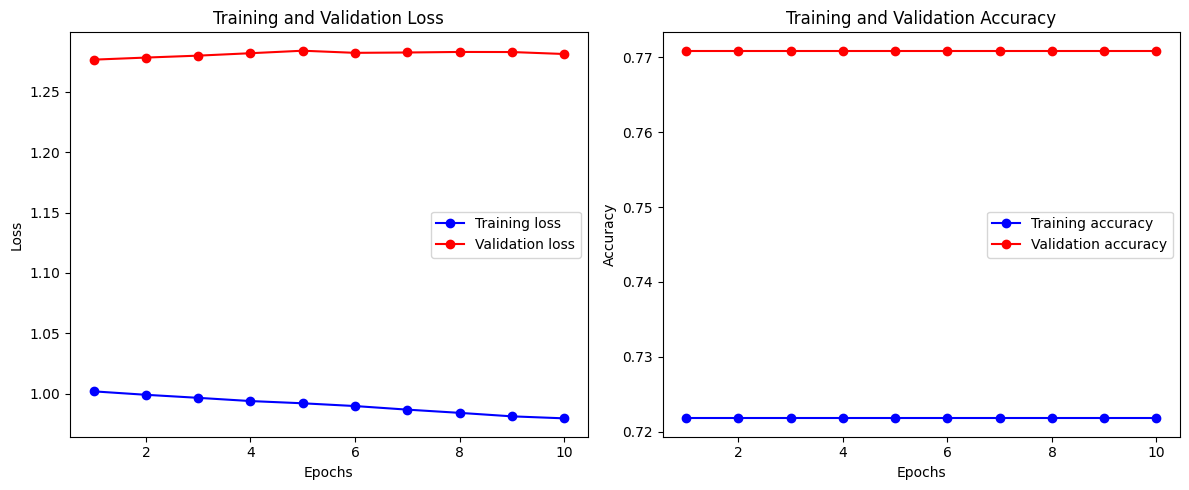

In [ ]:
import matplotlib.pyplot as plt

# Accessing the history data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Creating plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()